## Experiment-0:  COCO

Training params:
    - Network: VAE
    - Batch size: 64
    - Image type: Full image
    - Background subtraction: False
    - Background subtraction value: 0.0
    - Image-size: 32 x 32
    - Optimizer: Adam
    - Initial LR: 0.001

In [1]:
import os
os.chdir("/nfs/students/winter-term-2020/project-4/yurtkulus/project-4")

%load_ext autoreload
%autoreload 2

In [2]:
from src.data.coco import COCODataModule
import torch
from src.models.vae.vae import VAE
from src.experiments.experiment import Experiment
from src.utils.pixelcnn import generate_images
from src.utils.ood_test import plot_roc_auc

import torch.nn.functional as F
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np

"""
    In order to obtain foreground and background images from COCO dataset, 
    uncomment the lines below.
"""
# from src.data.oodcoco.oodcoco.oodcoco import run
# run()

'\n    In order to obtain foreground and background images from COCO dataset, \n    uncomment the lines below.\n'

In [3]:
print(os.cpu_count())
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
seed_everything(42)

20
cuda:0


42

In [4]:
cocodata_person = COCODataModule(foreground_data_dir='./data/COCO/foreground_images/person', 
                                 background_data_dir='./data/COCO/background_images/person', 
                                 convert_grayscale=True, 
                                 normalize=True)
cocodata_person.prepare_data()
cocodata_person.setup()

# cocodata_car = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/car', 
#                               background_data_dir='./data/COCO/background_images/car', 
#                               convert_grayscale=True, 
#                               normalize=True)

# cocodata_dog = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/dog', 
#                               background_data_dir='./data/COCO/background_images/dog', 
#                               convert_grayscale=True, 
#                               normalize=True)

# cocodata_teddy_bear = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/teddy bear', 
#                               background_data_dir='./data/COCO/background_images/teddy bear/', 
#                               convert_grayscale=True, 
#                               normalize=True)

# cocodata_umbrella = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/umbrella', 
#                               background_data_dir='./data/COCO/background_images/umbrella', 
#                               convert_grayscale=True, 
#                               normalize=True)

# cocodata_clock = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/clock', 
#                               background_data_dir='./data/COCO/background_images/clock', 
#                               convert_grayscale=True, 
#                               normalize=True)


experiment_name = 'VAE_COCO_Full_Img_Var_Learning'

# experiment_name = 'VAE_COCO_Full_Image'

early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.0000,
   patience=25,
   verbose=True,
)

logger = TensorBoardLogger(
            'lightning_logs', name=experiment_name)

trainer = Trainer(max_epochs=50, gpus=1, logger=logger,  
                  callbacks=[early_stop_callback], auto_lr_find=True, num_sanity_val_steps=0)


EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [5]:
model = VAE(lr=1e-3)

trainer.fit(model, cocodata_person)

Set SLURM handle signals.

  | Name     | Type          | Params
-------------------------------------------
0 | encoder  | ResNetEncoder | 11 M  
1 | decoder  | ResNetDecoder | 8 M   
2 | fc_mu    | Linear        | 131 K 
3 | fc_var   | Linear        | 131 K 
4 | fc_mu_x  | Linear        | 9 M   
5 | fc_var_x | Linear        | 9 M   


1

In [6]:
from pathlib import Path

path = Path('models/' + experiment_name)
path.mkdir(parents=True, exist_ok=True)


trainer.save_checkpoint(str(path) + '/' + experiment_name + '.ckpt')

In [7]:
model_path = str(path) + '/' + experiment_name + '.ckpt'
eval_VAE_full_img = VAE(lr=1e-3).load_from_checkpoint(checkpoint_path=model_path).cuda()
eval_VAE_full_img.eval()
test = cocodata_person.test_dataloader()

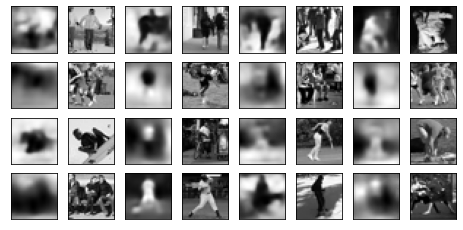

In [13]:
columns = 4
rows = 4
fig = plt.figure(figsize=(8, 8))
i = 1
for img in iter(test):
    if i <= (columns * rows) * 2:
        fig.add_subplot(rows * 2, columns * 2, i)
        img = img[0][0]
        img = img.repeat(1, 3, 1, 1)
        out = eval_VAE_full_img(img.cuda())
        reconstructed_img = out[0, 0, :, :]
        plt.imshow(reconstructed_img.detach().cpu().numpy(), cmap="gray")
        plt.xticks([])
        plt.yticks([])
        
        fig.add_subplot(rows * 2, columns * 2, i+1)
        plt.imshow(img[0, 0, :, :].detach().cpu().numpy(), cmap="gray")
        plt.xticks([])
        plt.yticks([])
    i += 2
plt.show()

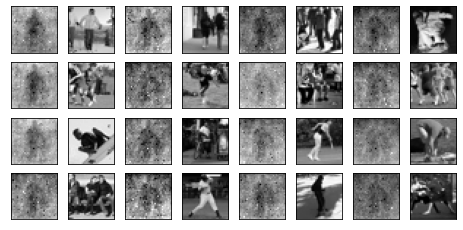

In [8]:
columns = 4
rows = 4
fig = plt.figure(figsize=(8, 8))
i = 1
for img in iter(test):
    if i <= (columns * rows) * 2:
        fig.add_subplot(rows * 2, columns * 2, i)
        img = img[0][0]
        img = img.repeat(1, 3, 1, 1)
        out = eval_VAE_full_img(img.cuda())
        reconstructed_img = out[0, 0, :, :]
        plt.imshow(reconstructed_img.detach().cpu().numpy(), cmap="gray")
        plt.xticks([])
        plt.yticks([])
        
        fig.add_subplot(rows * 2, columns * 2, i+1)
        plt.imshow(img[0, 0, :, :].detach().cpu().numpy(), cmap="gray")
        plt.xticks([])
        plt.yticks([])
    i += 2
plt.show()

In [17]:
from src.utils.vae import compute_pixelwise_expectation_and_variance
img = next(iter(test))
compute_pixelwise_expectation_and_variance(eval_VAE_full_img, img[0][0])

Sample shape ====> torch.Size([20, 32, 32])
Expectation shape ===> torch.Size([32, 32])
Variance shape ====> torch.Size([32, 32])
Org pixel values =====> tensor([[[[0.5843, 0.4588, 0.4980,  ..., 0.3137, 0.2980, 0.6039],
          [0.3804, 0.2824, 0.3451,  ..., 0.3412, 0.3843, 0.8314],
          [0.1804, 0.2392, 0.4863,  ..., 0.6941, 0.3725, 0.6314],
          ...,
          [0.4784, 0.5608, 0.5216,  ..., 0.7686, 0.7725, 0.7647],
          [0.4314, 0.4549, 0.4784,  ..., 0.7647, 0.7686, 0.7647],
          [0.5020, 0.6118, 0.7333,  ..., 0.7647, 0.7608, 0.7647]]]])
Expected pixel values =====> tensor([[0.6158, 0.6220, 0.6215,  ..., 0.5832, 0.5725, 0.5706],
        [0.6126, 0.6126, 0.6198,  ..., 0.5858, 0.5684, 0.5729],
        [0.6237, 0.6242, 0.6303,  ..., 0.6135, 0.5974, 0.5981],
        ...,
        [0.5729, 0.5825, 0.5967,  ..., 0.6238, 0.6133, 0.6111],
        [0.6162, 0.6259, 0.6424,  ..., 0.6150, 0.6069, 0.6102],
        [0.6353, 0.6350, 0.6556,  ..., 0.5986, 0.5909, 0.6046]],
     

SystemExit: 0